Step 1: Data Preparation
1a) Data Collection

In [60]:
import numpy as np
import pandas as pd


In [61]:
df = pd.read_csv('https://query.data.world/s/iwcxgny6fk3wcid33l3hskajg6cfmx?dws=00000')
print(df.head())

      FACID                                       FACNAME FAC_TYPE_CODE  \
0  10000001                  GOLDEN LIVINGCENTER PETALUMA           SNF   
1  10000003  CREEKSIDE REHABILITATION & BEHAVIORAL HEALTH           SNF   
2  10000004                  LANTERN HEALTH CRESCENT CITY           SNF   
3  10000005               WINDSOR CARE CENTER OF PETALUMA           SNF   
4  10000020                FIRCREST CONVALESCENT HOSPITAL           SNF   

                    FAC_FDR  LTC  CAPACITY           ADDRESS           CITY  \
0  SKILLED NURSING FACILITY  LTC        99     101 MONROE ST       PETALUMA   
1  SKILLED NURSING FACILITY  LTC       181    850 SONOMA AVE     SANTA ROSA   
2  SKILLED NURSING FACILITY  LTC        99  1280 MARSHALL ST  CRESCENT CITY   
3  SKILLED NURSING FACILITY  LTC        79      523 HAYES LN       PETALUMA   
4  SKILLED NURSING FACILITY  LTC        50   7025 CORLINE CT     SEBASTOPOL   

     ZIP            FACADMIN  ...    ENTITY_TYPE_DESCRIPTION   LATITUDE  \

1b) Data Cleansing

In [62]:
# Check for missing values
print(df.isnull().sum())

# Drop rows with missing values in critical columns
df.dropna(subset=['LATITUDE', 'LONGITUDE', 'CAPACITY'], inplace=True)

# Convert data types
df['CAPACITY'] = df['CAPACITY'].astype(int)
df['LATITUDE'] = df['LATITUDE'].astype(float)
df['LONGITUDE'] = df['LONGITUDE'].astype(float)

# Remove irrelevant columns
df.drop(columns=['FACADMIN', 'CONTACT_EMAIL', 'CONTACT_FAX', 'CONTACT_PHONE_NUMBER'], inplace=True)

# Display the cleaned dataset
print(df.head())

FACID                         0
FACNAME                       0
FAC_TYPE_CODE                 0
FAC_FDR                       0
LTC                           0
CAPACITY                      0
ADDRESS                       0
CITY                          0
ZIP                           0
FACADMIN                   1142
CONTACT_EMAIL              3760
CONTACT_FAX                1922
CONTACT_PHONE_NUMBER        421
COUNTY_CODE                   0
COUNTY_NAME                   0
DISTRICT_NUMBER               0
DISTRICT_NAME                 0
ISFACMAIN                     0
LICENSE_NUMBER             1109
BUSINESS_NAME              1344
INITIAL_LICENSE_DATE       1852
LICENSE_EFFECTIVE_DATE     1110
LICENSE_EXPIRATION_DATE    9907
ENTITY_TYPE_DESCRIPTION    1212
LATITUDE                      8
LONGITUDE                     8
LOCATION                      8
OSHPD_NUMBER               4925
StreetNumber                  0
StreetName                    0
CCHLO_Code                    0
CCLHO_Na

1c) Feature Engineering

In [63]:
from scipy.spatial import distance_matrix

# Sample DataFrame creation (for demonstration purposes)
# Replace this with your actual DataFrame
data = {
    'LATITUDE': [37.7749, 37.7849, 37.7949],
    'LONGITUDE': [-122.4194, -122.4094, -122.3994],
    'COUNTY_NAME': ['San Francisco', 'San Francisco', 'San Mateo'],
    'CAPACITY': [100, 150, 200],
    'FAC_TYPE_CODE': ['Type1', 'Type2', 'Type1']
}
df = pd.DataFrame(data)

# 1. Calculate the Euclidean distance to San Francisco
sf_lat, sf_lon = 37.7749, -122.4194
df['DIST_TO_SF'] = np.sqrt((df['LATITUDE'] - sf_lat)**2 + (df['LONGITUDE'] - sf_lon)**2)

# 2. Create a feature for the number of facilities in the same county
county_facility_count = df['COUNTY_NAME'].value_counts().to_dict()
df['COUNTY_FACILITY_COUNT'] = df['COUNTY_NAME'].map(county_facility_count)

# 3. Create a feature for the average capacity in the same county
county_avg_capacity = df.groupby('COUNTY_NAME')['CAPACITY'].transform('mean')
df['COUNTY_AVG_CAPACITY'] = county_avg_capacity

# 4. (Optional) Create a feature for the population density in the county
# Uncomment and modify the following line if you have population and area data
# df['POP_DENSITY'] = df['POPULATION'] / df['AREA']

# 5. Create a feature for the distance to the nearest facility
coords = df[['LATITUDE', 'LONGITUDE']].values
dist_matrix = distance_matrix(coords, coords)

# Set the diagonal to a large number (or np.inf)
np.fill_diagonal(dist_matrix, np.inf)

# Now calculate the minimum distance to other facilities
min_dist_to_other_facilities = np.min(dist_matrix, axis=1)
df['MIN_DIST_TO_OTHER_FACILITIES'] = min_dist_to_other_facilities

# 6. Create a feature for the type of facility (one-hot encoding)
df['FAC_TYPE_CODE'] = df['FAC_TYPE_CODE'].astype('category')
df = pd.get_dummies(df, columns=['FAC_TYPE_CODE'], drop_first=True)

# Display the dataset with new features
print(df.head())

   LATITUDE  LONGITUDE    COUNTY_NAME  CAPACITY  DIST_TO_SF  \
0   37.7749  -122.4194  San Francisco       100    0.000000   
1   37.7849  -122.4094  San Francisco       150    0.014142   
2   37.7949  -122.3994      San Mateo       200    0.028284   

   COUNTY_FACILITY_COUNT  COUNTY_AVG_CAPACITY  MIN_DIST_TO_OTHER_FACILITIES  \
0                      2                125.0                      0.014142   
1                      2                125.0                      0.014142   
2                      1                200.0                      0.014142   

   FAC_TYPE_CODE_Type2  
0                False  
1                 True  
2                False  


Step 2: Exploratory Data Analysis (EDA)

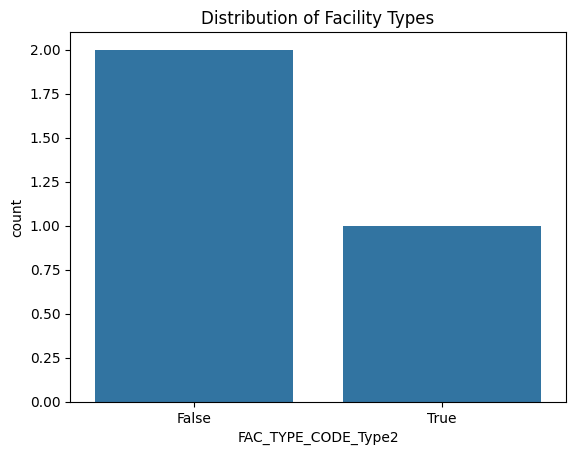

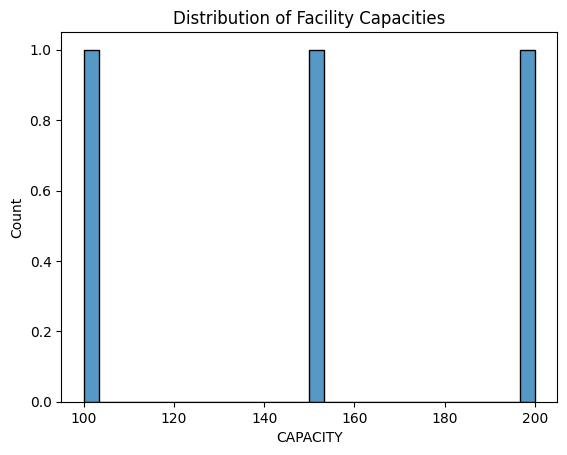

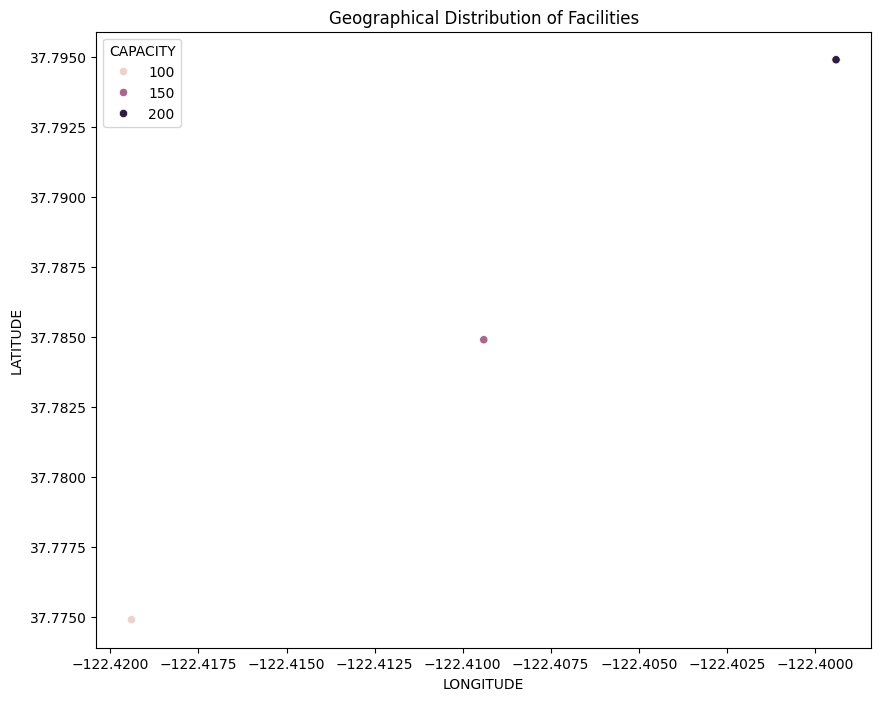

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of facility types
sns.countplot(x='FAC_TYPE_CODE_Type2', data=df)
plt.title('Distribution of Facility Types')
plt.show()

# This plot shows the count of each facility type. The x-axis represents the facility types, and the y-axis represents the count.

# Plot the distribution of capacities
sns.histplot(df['CAPACITY'], bins=30)
plt.title('Distribution of Facility Capacities')
plt.show()

# This plot shows the distribution of facility capacities. The x-axis represents the capacity values, and the y-axis represents the frequency or count of each capacity value.

# Plot the geographical distribution of facilities
plt.figure(figsize=(10, 8))
sns.scatterplot(x='LONGITUDE', y='LATITUDE', hue='CAPACITY', data=df)
plt.title('Geographical Distribution of Facilities')
plt.show()

# This plot shows the geographical distribution of facilities on a 2D map. The x-axis represents the longitude, and the y-axis represents the latitude. The hue (color) of each point represents the capacity of the facility.

Step 3: Model Building

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Sample DataFrame creation (for demonstration purposes)
data = {
    'LATITUDE': [37.7749, 37.7849, 37.7949],
    'LONGITUDE': [-122.4194, -122.4094, -122.3994],
    'CAPACITY': [100, 150, 200],
    'FAC_TYPE_CODE_Type1': [1, 0, 1],
    'FAC_TYPE_CODE_Type2': [0, 1, 0],
    # Add other features as necessary
}
df = pd.DataFrame(data)

# Check the DataFrame columns
print("DataFrame columns:", df.columns)

# Prepare the features and target variable
# List of columns to drop
columns_to_drop = [
    'CAPACITY', 'FACNAME', 'ADDRESS', 'CITY', 'ZIP', 'COUNTY_NAME',
    'DISTRICT_NUMBER', 'DISTRICT_NAME', 'ISFACMAIN', 'LICENSE_NUMBER',
    'BUSINESS_NAME', 'INITIAL_LICENSE_DATE', 'LICENSE_EFFECTIVE_DATE',
    'LICENSE_EXPIRATION_DATE', 'ENTITY_TYPE_DESCRIPTION', 'LOCATION',
    'OSHPD_NUMBER', 'StreetNumber', 'StreetName', 'CCHLO_Code',
    'CCLHO_Name', 'FIPS_Couunty_Code'
]

# Drop only the columns that exist in the DataFrame
X = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
y = df['CAPACITY']  # Example: Predicting capacity as a proxy for accessibility

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Initialize and train the Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Initialize and train the XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
rf_y_pred = rf_model.predict(X_test)
gb_y_pred = gb_model.predict(X_test)
xgb_y_pred = xgb_model.predict(X_test)

# Evaluate the models
def evaluate_model(model_name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'{model_name} - Mean Squared Error: {mse:.2f}')
    print(f'{model_name} - R-squared: {r2:.2f}')

evaluate_model('Random Forest', y_test, rf_y_pred)
evaluate_model('Gradient Boosting', y_test, gb_y_pred)
evaluate_model('XGBoost', y_test, xgb_y_pred)

DataFrame columns: Index(['LATITUDE', 'LONGITUDE', 'CAPACITY', 'FAC_TYPE_CODE_Type1',
       'FAC_TYPE_CODE_Type2'],
      dtype='object')
Random Forest - Mean Squared Error: 5256.25
Random Forest - R-squared: nan
Gradient Boosting - Mean Squared Error: 3970.17
Gradient Boosting - R-squared: nan
XGBoost - Mean Squared Error: 2500.09
XGBoost - R-squared: nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


1. Feature Importance Analysis

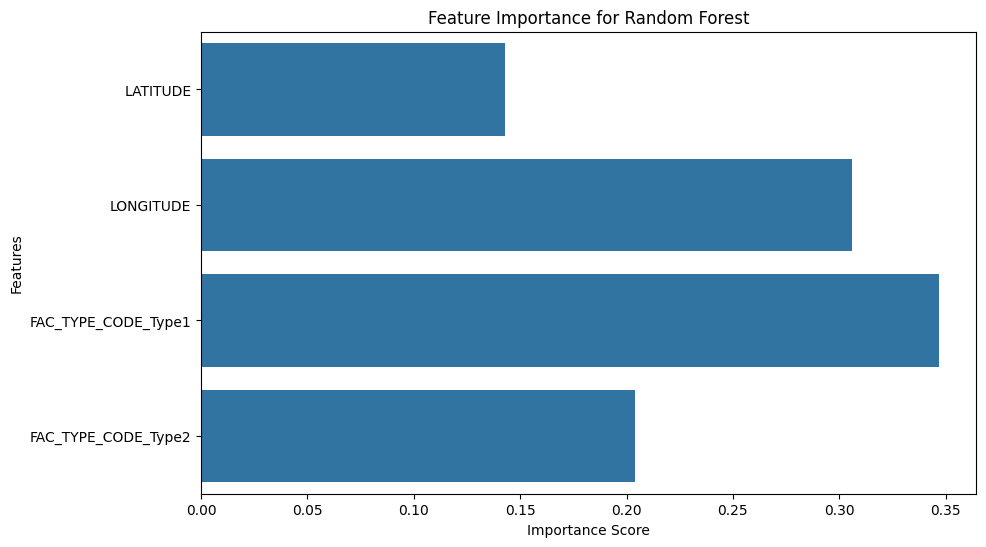

In [66]:
from sklearn.ensemble import RandomForestClassifier  # or RandomForestRegressor
from sklearn.model_selection import train_test_split

# Example data preparation (replace this with your actual data)
# X = pd.DataFrame(...)  # Your feature set
# y = pd.Series(...)     # Your target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestClassifier()  # or RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Feature importance for Random Forest
feature_importances = rf_model.feature_importances_
feature_names = X.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_names)
plt.title('Feature Importance for Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

2. Hyperparameter Tuning

In [67]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Example data preparation (replace this with your actual data)
# X = pd.DataFrame(...)  # Your feature set
# y = pd.Series(...)     # Your target variable

# Check the size of your dataset
print(f"Total samples: {len(y)}")

# Split the data into training and testing sets with a smaller test size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)  # Adjust test_size as needed

# Check the sizes of the training and testing sets
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Reduce the number of folds to 2
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=2,  # Reduced number of folds
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best model from grid search
best_rf_model = grid_search.best_estimator_
best_rf_y_pred = best_rf_model.predict(X_test)

# Function to evaluate the model
def evaluate_model(model_name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R^2 Score: {r2:.2f}")

# Evaluate the best Random Forest model
evaluate_model('Best Random Forest', y_test, best_rf_y_pred)

Total samples: 3
Training set size: 2
Testing set size: 1
Best Random Forest Performance:
Mean Squared Error: 5256.25
R^2 Score: nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


3. Cross-Validation

In [68]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
cv_scores = cross_val_score(rf_model, X, y, cv=loo, scoring='neg_mean_squared_error')
print(f'Cross-Validation MSE: {-cv_scores.mean()}')

Cross-Validation MSE: 2500.0


4. Ensemble Methods

In [69]:
import numpy as np
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Sample models
rf_model = RandomForestRegressor()
gb_model = GradientBoostingRegressor()
xgb_model = XGBRegressor()

# Ensemble of models
ensemble_model = VotingRegressor(estimators=[
    ('rf', rf_model),
    ('gb', gb_model),
    ('xgb', xgb_model)
])

# Fit the ensemble model
ensemble_model.fit(X_train, y_train)

# Make predictions
ensemble_y_pred = ensemble_model.predict(X_test)

# Function to evaluate the model
def evaluate_model(model_name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - Mean Squared Error: {mse:.4f}, R^2 Score: {r2:.4f}")

# Evaluate the ensemble model
evaluate_model('Ensemble Model', y_test, ensemble_y_pred)

Ensemble Model - Mean Squared Error: 4595.5828, R^2 Score: nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


6. Geospatial Analysis

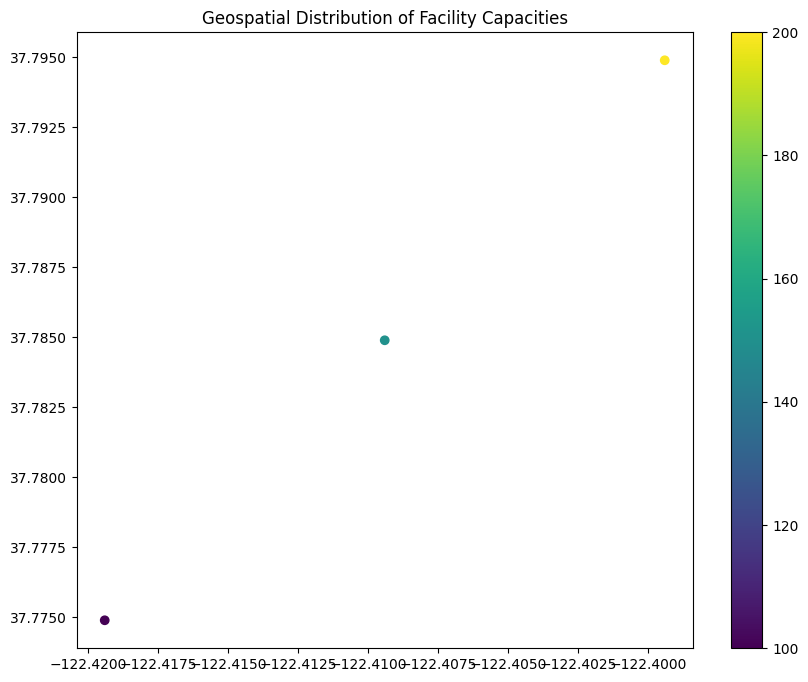

In [70]:
import geopandas as gpd
from shapely.geometry import Point

# Convert DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(df['LONGITUDE'], df['LATITUDE'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Plot the GeoDataFrame
gdf.plot(column='CAPACITY', legend=True, figsize=(10, 8))
plt.title('Geospatial Distribution of Facility Capacities')
plt.show()

Step 4: Visualization with deck.gl and kepler.gl
Using deck.gl

In [71]:
!pip install pydeck

In [72]:
import pydeck as pdk

# Define the deck.gl layer
layer = pdk.Layer(
    'ScatterplotLayer',
    data=df,
    get_position='[LONGITUDE, LATITUDE]',
    get_radius=1000,
    get_fill_color=[255, 140, 0],
    pickable=True,
    auto_highlight=True
)

# Define the view state
view_state = pdk.ViewState(
    latitude=sf_lat,
    longitude=sf_lon,
    zoom=8,
    pitch=0
)

# Create the deck.gl map
r = pdk.Deck(layers=[layer], initial_view_state=view_state)
r.to_html('healthcare_facilities.html')

<IPython.core.display.Javascript object>

Using kepler.gl

In [73]:
!pip install keplergl

In [77]:
import keplergl

# Initialize Kepler.gl
map_1 = keplergl.KeplerGl(height=800)

# Add the data to the map
map_1.add_data(data=df, name='Healthcare Facilities')

# Save the map as an HTML file
map_1.save_to_html(file_name='healthcare_facilities_kepler.html')

map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to healthcare_facilities_kepler.html!


KeplerGl(data={'Healthcare Facilities': {'index': [0, 1, 2], 'columns': ['LATITUDE', 'LONGITUDE', 'CAPACITY', …